In [39]:
from abc import ABC, abstractmethod
import pandas as pd
import numpy as np
import itertools
import json
import copy
import time
from typing import Tuple

class LiteratureGameAbstract(ABC):
    def __init__(
            self, 
            team_count : int,
            player_count : int,
            set_count : int = 8,
            set_card_count : int = 6,
        ) -> None:
        
        self.set_count = set_count
        self.set_card_count = set_card_count
        
        self.team_count = team_count
        self.player_count = player_count
        
        self.check_game_inputs()
        
    def check_game_inputs(self) -> None:

        inputs = {
            "team_count" : self.team_count, 
            "player_count" : self.player_count, 
            "set_count" : self.set_count, 
            "set_card_count" : self.set_card_count
        }

        issue_inputs = [key for key, value in inputs.items() if isinstance(value, int) == False]
        if len(issue_inputs) > 0:
            raise ValueError(f"Inputs must be integers: {issue_inputs}")
        
        if self.player_count%self.team_count != 0:
            raise ValueError(f"player_count must be divisible by team_count: {self.player_count} % {self.team_count} != 0")
        if self.total_card_count%self.player_count != 0:
            raise ValueError(f"total_card_count must be divisible by player_count: {self.total_card_count} % {self.player_count} != 0")

    @property
    def total_card_count(self) -> int:
        return self.set_count*self.set_card_count

    @property
    def player_per_team_count(self) -> int:
        return self.player_count//self.team_count

    @property
    def card_per_player_count(self) -> int:
        return self.total_card_count//self.player_count

class LiteratureBotAbstract(LiteratureGameAbstract):
    def __init__(
            self, 
            team_id : int,
            player_id : int,
            team_count : int,
            player_count : int,
            initial_game_state_array : np.ndarray = None,
            set_count : int = 8,
            set_card_count : int = 6,
            fake_game_seed : int = None
        ) -> None:
        
        super().__init__(
            team_count = team_count,
            player_count = player_count,
            set_count = set_count,
            set_card_count = set_card_count
        )

        self.team_id = team_id
        self.player_id = player_id

        self.initial_game_state_array = initial_game_state_array
        self.fake_game_seed = fake_game_seed
        
        self.check_bot_inputs()

        if self.fake_game_seed is not None:
            (
                self._fake_initial_game_state_array,
                self._fake_initial_card_location_array
            ) = self.initialize_fake_game()
        elif self.initial_game_state_array is None:
            raise ValueError("Must provide either game_state_array or fake_game_seed")
        
    def check_bot_inputs(self) -> None:

        inputs = {
            "team_id" : self.team_id, 
            "player_id" : self.player_id,
        }

        issue_inputs = [key for key, value in inputs.items() if isinstance(value, int) == False]
        if len(issue_inputs) > 0:
            raise ValueError(f"Inputs must be integers: {issue_inputs}")
        if self.initial_game_state_array is not None and isinstance(self.initial_game_state_array, np.ndarray) == False:
            raise ValueError(f"initial_game_state_array must be a numpy.ndarray: {type(self.initial_game_state_array)}")
        if self.fake_game_seed is not None and isinstance(self.fake_game_seed, int) == False:
            raise ValueError(f"fake_game_seed must be an integer: {type(self.fake_game_seed)}")
        
        if self.team_id >= self.team_count:
            raise ValueError(f"team_id must be less than team_count: {self.team_id} >= {self.team_count}")
        if self.player_id >= self.player_per_team_count:
            raise ValueError(f"player_id must be less than player_count_per_team: {self.player_id} >= {self.player_per_team_count}")

    def initialize_fake_game(self) -> Tuple[np.ndarray, np.ndarray]:
        dummy_card_location_array = np.tile(np.arange(self.player_count), self.card_per_player_count).reshape(-1)
        np.random.seed(self.fake_game_seed)
        np.random.shuffle(dummy_card_location_array)
        card_location_array = dummy_card_location_array.reshape(self.set_count, self.set_card_count)
        
        game_state_array = np.array(
            [np.where(card_location_array == i, 1, 0).tolist() for i in range(self.player_count)]
        ).reshape(self.team_count, self.player_per_team_count, self.set_count, self.set_card_count)

        return game_state_array, card_location_array

    @abstractmethod
    def initialize_matrix(self) -> Tuple:
        pass

    @abstractmethod
    def update_game(self, game_action_dict, stop = True) -> None:
        pass

class LitBot(LiteratureBotAbstract):
    EPSILON = 0.01
    def __init__(
        self, 
        team_id : int, 
        player_id : int,
        team_count : int,
        player_count : int,
        initial_game_state_array : np.ndarray = None, 
        fake_game_seed : int = None
    ) -> None:

        super().__init__(
            team_id = team_id,
            player_id = player_id,
            team_count = team_count,
            player_count = player_count,
            initial_game_state_array = initial_game_state_array,
            fake_game_seed = fake_game_seed
        )

        if self.initial_game_state_array is not None:
            self.initialize_matrix()
    
    def initialize_matrix(self) -> None:

        self.information_matrix = np.full((self.team_count, self.player_per_team_count, self.set_count, self.set_card_count), LitBot.EPSILON)
        for team_idx, player_idx in itertools.product(range(self.team_count), range(self.player_per_team_count)):
            self.information_matrix[team_idx, player_idx, :, :] = np.where(
                self.initial_game_state_array == 1, 
                1 if (team_idx == self.team_id) and (player_idx == self.player_id) else 0,
                0 if (team_idx == self.team_id) and (player_idx == self.player_id) else LitBot.EPSILON
            )

        self.player_set_card_count = np.full((self.team_count, self.player_per_team_count, self.set_count), LitBot.EPSILON)
        self.player_set_card_count[self.team_id, self.player_id, :] =  self.initial_game_state_array.sum(axis=1)
        
        self.player_card_count = np.full((self.team_count, self.player_per_team_count), self.total_card_count//self.player_count)
        
        self.active_sets = np.full((self.set_count), LitBot.EPSILON)
        self.active_cards = np.full((self.set_count, self.set_card_count), LitBot.EPSILON)
        self.recent_card_array = np.full((self.team_count, self.set_count), LitBot.EPSILON)
        
        self.inferences_list = {}
        self.conflict_inferences_list = {}
        self.out_of_date_inferences_list = {}

        self.statistics = {
            "shannon_info" : [],
            "dumb_shannon_info" : [],
            "inference_length" : [],
        }

        # self.initialize_experimental_arrays()

    # def initialize_experimental_arrays(self):

    #     self.players_in_set = np.full((self.team_count, self.player_per_team_count, self.set_count), LitBot.EPSILON)
    #     self.information_matrix[self.team_id, self.player_id].sum()
    #     self.players_in_set[self.team_id, self.player_id, :] = np.where(self.information_matrix[self.team_id,self.player_id].sum(axis=1)>=1, 1, 0)

    #     self.uninferred_cards_count_matrix = np.full((self.team_count, self.player_per_team_count, self.set_count), LitBot.EPSILON)

    #     self.card_owner = copy.deepcopy(self.information_matrix)
    #     self.asked_cards = np.zeros((self.set_count, self.set_card_count))

    def update_information_matrix_hard(self, card_info, ask_player, ans_player, result, move_id):

        if result == 0:
            assert ans_player is not None
            assert self.information_matrix[ask_player["team_id"], ask_player["player_id"], card_info["set_id"], card_info["card_id"]] != 1
            assert self.information_matrix[ans_player["team_id"], ans_player["player_id"], card_info["set_id"], card_info["card_id"]] != 1
            print(f"{move_id} : updated information matrix for {card_info['set_id'], card_info['card_id']} for result 0 : hard")
            self.information_matrix[ask_player["team_id"], ask_player["player_id"], card_info["set_id"], card_info["card_id"]] = 0
            self.information_matrix[ans_player["team_id"], ans_player["player_id"], card_info["set_id"], card_info["card_id"]] = 0
        if result == 1:
            
            # use better assert condition later
            # assert self.information_matrix[ask_player["team_id"], ask_player["player_id"], card_info["set_id"], card_info["card_id"]] != 1
            
            print(f"{move_id} : updated information matrix for {card_info['set_id'], card_info['card_id']} for result 1 : hard")
            self.information_matrix[:, :, card_info["set_id"], card_info["card_id"]] = 0
            self.information_matrix[ask_player["team_id"], ask_player["player_id"], card_info["set_id"], card_info["card_id"]] = 1
            if ans_player is not None:
                print(f"{move_id} : updated player card count matrix for {card_info['set_id'], card_info['card_id']} for result 1 : hard")
                self.player_card_count[ask_player["team_id"], ask_player["player_id"]] += 1
                self.player_card_count[ans_player["team_id"], ans_player["player_id"]] -= 1

    def update_active_arrays(self, team_id, set_id, card_id, action, result):
        if action == "ask_card":
            assert card_id is not None
            if result == 0:
                self.active_cards[set_id, card_id] = 1
                self.recent_card_array[team_id, set_id] = card_id
            else:
                self.active_cards[set_id, card_id] = 0
            self.active_sets[set_id] = 1
        if action == "call_set":
            self.active_cards[set_id, :] = 0
            self.active_sets[set_id] = 0


    # def update_card_owner(self, move_id, card_info, ask_player, ans_player, result):

    #     if (self.asked_cards[card_info["set_id"], card_info["card_id"]] == 0) and (result == 1):
    #         self.card_owner[:, :, card_info["set_id"], card_info["card_id"]] = 0
    #         self.card_owner[ask_player["team_id"], ask_player["player_id"], card_info["set_id"], card_info["card_id"]] = 1
    #         self.asked_cards[card_info["set_id"], card_info["card_id"]] = 1

    # def update_base_card_inference_list(self, move_id, card_info, ask_player, ans_player, result):

    #     # detect untracked player set combination and add to the list
    #     # if 
    #     detect = False
    #     if 

    #     #  

    def update_player_set_card_count(self, move_id, card_info, ask_player, ans_player, result, action):
        
        if action == "ask_card":
            if self.inference_matrix[ask_player["team_id"], ask_player["player_id"], card_info["set_id"]].sum() == 0:
                if self.player_set_card_count[ask_player["team_id"], ask_player["player_id"], card_info["set_id"]] == LitBot.EPSILON:
                    self.player_set_card_count[ask_player["team_id"], ask_player["player_id"], card_info["set_id"]] = 1

        if ans_player is None:
            self.player_set_card_count[ask_player["team_id"], ask_player["player_id"], card_info["set_id"]] = len(card_info["card_locations"])
            for i, card_id in enumerate(card_info["card_locations"]):
                self.player_set_card_count[ask_player["team_id"], ask_player["player_locations"][i], card_info["set_id"]] = 0
            self.player_set_card_count[ask_player["team_id"], ask_player["player_id"], card_info["set_id"]] 

    def update_inference_list(self, team_id, player_id, set_id, card_id, move_id):
        
        # detecting new inference and adding to the list
        detect = False
        if (self.recent_card_array[team_id, set_id] != card_id) and (self.recent_card_array[team_id, set_id] != LitBot.EPSILON):
            print(f"{move_id} : new inference detected for {set_id, self.recent_card_array[team_id, set_id]} for player {team_id, player_id} : inference")
            new_inference = {
                "team_id" : team_id, 
                "player_id" : player_id, 
                "set_id" : set_id, 
                "card_id" : int(self.recent_card_array[team_id, set_id])
            }
            self.inferences_list[move_id] = new_inference
            detect = True

        # cleaning the list for conflicts and out-of-dates
        for id, inference in self.inferences_list.items():
            info = self.information_matrix[:, :, inference["set_id"], inference["card_id"]]

            if info[inference["team_id"], inference["player_id"]] == 0:
                print(f"{move_id} : conflict inference detected with info matrix {id}")
                self.conflict_inferences_list[id] = inference
                continue
            elif info[inference["team_id"], inference["player_id"]] == 1:
                print(f"{move_id} : out of date inference detected with info matrix {id}")
                self.out_of_date_inferences_list[id] = inference
                continue
        
        for id, _ in (self.conflict_inferences_list | self.out_of_date_inferences_list).items():
            try:
                self.inferences_list.pop(id)
            except:
                pass

        # remove internal inference conflicts:
        repeat_id = None
        conflict_id = None
        if detect and move_id in self.inferences_list:
            for id, inference in self.inferences_list.items():
                if id != move_id:
                    if (inference["set_id"] != new_inference["set_id"]) or (inference["card_id"] != new_inference["card_id"]):
                        continue
                    elif (inference["team_id"] == team_id) or (inference["player_id"] == player_id):
                        print(f"{move_id} : new inference detected is already captured : inference")
                        repeat_id = id
                        continue
                    else:
                        print(f"{move_id} : conflict inference detected for {new_inference['set_id'], new_inference['card_id']} for player {team_id, player_id} : inference")
                        conflict_id = id

        if repeat_id is not None:
            self.inferences_list.pop(repeat_id)
        if conflict_id is not None:
            self.conflict_inferences_list[conflict_id] = self.inferences_list[conflict_id]
            self.inferences_list.pop(conflict_id)

    def completeness_check_hard(self, move_id):
        # card location has to be atleast 1
        for set_id, card_id in itertools.product(range(self.set_count), range(self.set_card_count)):
            if self.information_matrix[:, :, set_id, card_id].sum() == LitBot.EPSILON:
                print(f"{move_id} : epsilon to 1 completeness for {set_id, card_id} : hard")
                self.information_matrix[:, :, set_id, card_id] //= LitBot.EPSILON

        # player card count match
        for team_id, player_id in np.argwhere(self.truth_matrix.sum(axis=(2,3))==self.player_card_count).tolist():
            print(f"{move_id} : player card count completeness for {team_id, player_id} : hard")
            self.information_matrix[team_id, player_id] = np.where(self.information_matrix[team_id, player_id] == LitBot.EPSILON, 0, self.information_matrix[team_id, player_id])

        # set card count match
        for set_id in np.argwhere(self.truth_matrix.sum(axis=(0,1,3))==self.set_card_count).tolist():
            print(f"{move_id} : set card count completeness for {set_id} : hard")
            self.information_matrix[:, :, set_id] = np.where(self.information_matrix[:, :, set_id] == LitBot.EPSILON, 0, self.information_matrix[:, :, set_id])        

    def update_statistics(self):
        self.statistics["shannon_info"].append(self.shannon_info_matrix.sum())
        self.statistics["dumb_shannon_info"].append(self.dumb_shannon_info_matrix.sum())
        self.statistics["inference_length"].append(self.inferences_list.__len__())

    def update_game(self, game_action_dict, stop = True):

        move_id = list(game_action_dict.keys())[0]
        game_action_dict = game_action_dict[move_id]
        action = game_action_dict["action"]
        team_id = game_action_dict["by_team"]
        player_id = game_action_dict["by"]
        set_id = game_action_dict["set_id"]
        result = game_action_dict["result"]
        # print(result)
        card_id = None
        ans_team_id = None

        if action == "ask_card":
            ans_team_id = game_action_dict["to_team"]
            ans_player_id = game_action_dict["to"]
            card_id = game_action_dict["card_id"]

            self.update_information_matrix_hard(
                card_info = {"set_id" : set_id, "card_id" : card_id},
                ask_player = {"team_id" : team_id, "player_id" : player_id},
                ans_player = {"team_id" : ans_team_id, "player_id" : ans_player_id},
                result = result,
                move_id = move_id
            )

            # self.update_card_owner(
            #     move_id, 
            #     card_info = {"set_id" : set_id, "card_id" : card_id}, 
            #     ask_player = {"team_id" : team_id, "player_id" : player_id}, 
            #     ans_player = {"team_id" : ans_team_id, "player_id" : ans_player_id}, 
            #     result = result
            # )

        elif action == "call_set":
            card_locations = game_action_dict["card_locations"]
            for card_id, player_id in card_locations.items():
                card_id = int(card_id)

                self.update_information_matrix_hard(
                    card_info = {"set_id" : set_id, "card_id" : card_id},
                    ask_player = {"team_id" : team_id, "player_id" : player_id},
                    ans_player = None,
                    result = 1,
                    move_id = move_id
                )
        else:
            pass
        

        self.completeness_check_hard(move_id)
        self.update_inference_list(team_id, player_id, set_id, card_id, move_id)
        self.update_active_arrays(team_id, set_id, card_id, action, result)
        # self.update_uninferred_cards_count_matrix()
        # if action == "ask_card":
        #     self.update_player_set_card_count(
        #         move_id = move_id,
        #         card_info = {"set_id" : set_id, "card_id" : card_id},
        #         ask_player = {"team_id" : team_id, "player_id" : player_id},
        #         ans_player = {"team_id" : ans_team_id, "player_id" : ans_player_id},
        #         result = result
        #     )
        # elif action == "call_set":
            # self.update_player_set_card_count(
            #     move_id = move_id,
            #     card_info = {"set_id" : set_id, "card_locations" : [card_id for card_id, _ in card_locations.items()]},
            #     ask_player = {"team_id" : team_id, "player_locations" : [player_id for _, player_id in card_locations.items()]},
            #     ans_player = None,
            #     result = 1
            # )
        self.update_statistics()

    @property
    def inference_multiplier_matrix(self):
        inference_multiplier_matrix = np.full((self.team_count, self.player_per_team_count, self.set_count, self.set_card_count), 1)
        for _, inference in self.inferences_list.items():
            team_id = inference["team_id"]
            player_id = inference["player_id"]
            set_id = int(inference["set_id"])
            card_id = int(inference["card_id"])
            inference_multiplier_matrix[:, :, set_id, card_id] = 0
            inference_multiplier_matrix[team_id, player_id, set_id, card_id] = 1
        return inference_multiplier_matrix

    @property
    def set_card_count_inference_multiplier_matrix(self):
        set_card_count_inference_multiplier_matrix = np.full((self.team_count, self.player_per_team_count, self.set_count, self.set_card_count), 1)
        for set_id in np.argwhere(self.player_set_card_count.sum(axis=(0,1)) == self.set_card_count).tolist():
            for team_id, player_id in np.argwhere(self.player_set_card_count[:, :, set_id]==0).tolist():
                set_card_count_inference_multiplier_matrix[team_id, player_id, set_id] = 0
        return set_card_count_inference_multiplier_matrix

    @property
    def player_card_count_inference_multiplier_matrix(self):
        player_card_count_inference_multiplier_matrix = np.full((self.team_count, self.player_per_team_count, self.set_count, self.set_card_count), 1)
        for team_id, player_id in np.argwhere(self.player_set_card_count.sum(axis=(2)) == self.player_card_count).tolist():
            for set_id in np.argwhere(self.player_set_card_count[team_id, player_id, :] == 0).tolist():
                player_card_count_inference_multiplier_matrix[team_id, player_id, set_id] = 0
        return player_card_count_inference_multiplier_matrix

    @property
    def truth_matrix(self):
        info_matrix = np.where(self.information_matrix == LitBot.EPSILON, 0, self.information_matrix)
        return info_matrix

    @property
    def inference_matrix(self):
        inference_matrix = np.full((self.team_count, self.player_per_team_count, self.set_count, self.set_card_count), 0)
        for _, inference in self.inferences_list.items():
            team_id = inference["team_id"]
            player_id = inference["player_id"]
            set_id = int(inference["set_id"])
            card_id = int(inference["card_id"])
            inference_matrix[team_id, player_id, set_id, card_id] = 1
        inference_matrix = self.truth_matrix + inference_matrix
        return inference_matrix

    @property
    def prob_matrix(self):
        info_matrix = np.where(self.information_matrix == LitBot.EPSILON, 1, self.information_matrix)
        integrated_info_matrix = (
            info_matrix
            *self.inference_multiplier_matrix
            # *self.set_card_count_inference_multiplier_matrix
            # *self.player_card_count_inference_multiplier_matrix
        )
        prob_matrix = integrated_info_matrix/integrated_info_matrix.sum(axis=(0,1))
        return prob_matrix
    
    @property
    def dumb_prob_matrix(self):
        info_matrix = np.where(self.information_matrix == LitBot.EPSILON, 1, self.information_matrix)
        prob_matrix = info_matrix/info_matrix.sum(axis=(0,1))
        return prob_matrix

    @property
    def dumb_shannon_info_matrix(self):
        uncertainity_matrix = self.dumb_prob_matrix.max(axis=(0, 1))
        shannon_info_matrix = self.total_shannon_info + np.log2(uncertainity_matrix)
        return shannon_info_matrix
    
    @property
    def shannon_info_matrix(self):
        uncertainity_matrix = self.prob_matrix.max(axis=(0, 1))
        shannon_info_matrix = self.total_shannon_info + np.log2(uncertainity_matrix)
        return shannon_info_matrix
    
    @property
    def total_shannon_info(self):
        return -np.log2(np.full((8,6), 1/self.player_count))

In [153]:
from abc import ABC, abstractmethod
import pandas as pd
import numpy as np
import itertools
import json
import copy
import time
from typing import Tuple

class LiteratureGameAbstract(ABC):
    def __init__(
            self, 
            team_count : int,
            player_count : int,
            set_count : int = 8,
            set_card_count : int = 6,
        ) -> None:
        
        self.set_count = set_count
        self.set_card_count = set_card_count
        
        self.team_count = team_count
        self.player_count = player_count
        
        self.check_game_inputs()
        
    def check_game_inputs(self) -> None:

        inputs = {
            "team_count" : self.team_count, 
            "player_count" : self.player_count, 
            "set_count" : self.set_count, 
            "set_card_count" : self.set_card_count
        }

        issue_inputs = [key for key, value in inputs.items() if isinstance(value, int) == False]
        if len(issue_inputs) > 0:
            raise ValueError(f"Inputs must be integers: {issue_inputs}")
        
        if self.player_count%self.team_count != 0:
            raise ValueError(f"player_count must be divisible by team_count: {self.player_count} % {self.team_count} != 0")
        if self.total_card_count%self.player_count != 0:
            raise ValueError(f"total_card_count must be divisible by player_count: {self.total_card_count} % {self.player_count} != 0")

    @property
    def total_card_count(self) -> int:
        return self.set_count*self.set_card_count

    @property
    def player_per_team_count(self) -> int:
        return self.player_count//self.team_count

    @property
    def card_per_player_count(self) -> int:
        return self.total_card_count//self.player_count

class LiteratureBotAbstract(LiteratureGameAbstract):
    def __init__(
            self, 
            team_id : int,
            player_id : int,
            team_count : int,
            player_count : int,
            initial_game_state_array : np.ndarray = None,
            set_count : int = 8,
            set_card_count : int = 6,
            fake_game_seed : int = None
        ) -> None:
        
        super().__init__(
            team_count = team_count,
            player_count = player_count,
            set_count = set_count,
            set_card_count = set_card_count
        )

        self.team_id = team_id
        self.player_id = player_id

        self.initial_game_state_array = initial_game_state_array
        self.fake_game_seed = fake_game_seed
        
        self.check_bot_inputs()

        if self.fake_game_seed is not None:
            (
                self._fake_initial_game_state_array,
                self._fake_initial_card_location_array
            ) = self.initialize_fake_game()
        elif self.initial_game_state_array is None:
            raise ValueError("Must provide either game_state_array or fake_game_seed")
        
    def check_bot_inputs(self) -> None:

        inputs = {
            "team_id" : self.team_id, 
            "player_id" : self.player_id,
        }

        issue_inputs = [key for key, value in inputs.items() if isinstance(value, int) == False]
        if len(issue_inputs) > 0:
            raise ValueError(f"Inputs must be integers: {issue_inputs}")
        if self.initial_game_state_array is not None and isinstance(self.initial_game_state_array, np.ndarray) == False:
            raise ValueError(f"initial_game_state_array must be a numpy.ndarray: {type(self.initial_game_state_array)}")
        if self.fake_game_seed is not None and isinstance(self.fake_game_seed, int) == False:
            raise ValueError(f"fake_game_seed must be an integer: {type(self.fake_game_seed)}")
        
        if self.team_id >= self.team_count:
            raise ValueError(f"team_id must be less than team_count: {self.team_id} >= {self.team_count}")
        if self.player_id >= self.player_per_team_count:
            raise ValueError(f"player_id must be less than player_count_per_team: {self.player_id} >= {self.player_per_team_count}")

    def initialize_fake_game(self) -> Tuple[np.ndarray, np.ndarray]:
        dummy_card_location_array = np.tile(np.arange(self.player_count), self.card_per_player_count).reshape(-1)
        np.random.seed(self.fake_game_seed)
        np.random.shuffle(dummy_card_location_array)
        card_location_array = dummy_card_location_array.reshape(self.set_count, self.set_card_count)
        
        game_state_array = np.array(
            [np.where(card_location_array == i, 1, 0).tolist() for i in range(self.player_count)]
        ).reshape(self.team_count, self.player_per_team_count, self.set_count, self.set_card_count)

        return game_state_array, card_location_array

    @abstractmethod
    def initialize_matrix(self) -> Tuple:
        pass

    @abstractmethod
    def update_game(self, game_action_dict, stop = True) -> None:
        pass

class LitBot(LiteratureBotAbstract):
    EPSILON = 0.01
    def __init__(
        self, 
        team_id : int, 
        player_id : int,
        team_count : int,
        player_count : int,
        initial_game_state_array : np.ndarray = None, 
        fake_game_seed : int = None
    ) -> None:

        super().__init__(
            team_id = team_id,
            player_id = player_id,
            team_count = team_count,
            player_count = player_count,
            initial_game_state_array = initial_game_state_array,
            fake_game_seed = fake_game_seed
        )

        if self.initial_game_state_array is not None:
            self.initialize_matrix()
    
    def initialize_matrix(self) -> None:

        self.information_matrix = np.full((self.team_count, self.player_per_team_count, self.set_count, self.set_card_count), LitBot.EPSILON)
        for team_idx, player_idx in itertools.product(range(self.team_count), range(self.player_per_team_count)):
            self.information_matrix[team_idx, player_idx, :, :] = np.where(
                self.initial_game_state_array == 1, 
                1 if (team_idx == self.team_id) and (player_idx == self.player_id) else 0,
                0 if (team_idx == self.team_id) and (player_idx == self.player_id) else LitBot.EPSILON
            )

        self.player_set_card_count = np.full((self.team_count, self.player_per_team_count, self.set_count), LitBot.EPSILON)
        self.player_set_card_count[self.team_id, self.player_id, :] =  self.initial_game_state_array.sum(axis=1)
        
        self.player_card_count = np.full((self.team_count, self.player_per_team_count), self.total_card_count//self.player_count)
        
        self.active_sets = np.full((self.set_count), LitBot.EPSILON)
        self.active_cards = np.full((self.set_count, self.set_card_count), LitBot.EPSILON)
        self.recent_card_array = np.full((self.team_count, self.set_count), LitBot.EPSILON)
        
        self.inferences_list = {}
        self.conflict_inferences_list = {}
        self.out_of_date_inferences_list = {}

        self.statistics = {
            "shannon_info" : [],
            "dumb_shannon_info" : [],
            "inference_length" : [],
        }

        # self.initialize_experimental_arrays()

    # def initialize_experimental_arrays(self):

    #     self.players_in_set = np.full((self.team_count, self.player_per_team_count, self.set_count), LitBot.EPSILON)
    #     self.information_matrix[self.team_id, self.player_id].sum()
    #     self.players_in_set[self.team_id, self.player_id, :] = np.where(self.information_matrix[self.team_id,self.player_id].sum(axis=1)>=1, 1, 0)

    #     self.uninferred_cards_count_matrix = np.full((self.team_count, self.player_per_team_count, self.set_count), LitBot.EPSILON)

    #     self.card_owner = copy.deepcopy(self.information_matrix)
    #     self.asked_cards = np.zeros((self.set_count, self.set_card_count))

    def update_information_matrix_hard(self, card_info, ask_player, ans_player, result, move_id):

        if result == 0:
            assert ans_player is not None
            assert self.information_matrix[ask_player["team_id"], ask_player["player_id"], card_info["set_id"], card_info["card_id"]] != 1
            assert self.information_matrix[ans_player["team_id"], ans_player["player_id"], card_info["set_id"], card_info["card_id"]] != 1
            print(f"{move_id} : updated information matrix for {card_info['set_id'], card_info['card_id']} for result 0 : hard")
            self.information_matrix[ask_player["team_id"], ask_player["player_id"], card_info["set_id"], card_info["card_id"]] = 0
            self.information_matrix[ans_player["team_id"], ans_player["player_id"], card_info["set_id"], card_info["card_id"]] = 0
        if result == 1:
            
            # use better assert condition later
            # assert self.information_matrix[ask_player["team_id"], ask_player["player_id"], card_info["set_id"], card_info["card_id"]] != 1
            
            print(f"{move_id} : updated information matrix for {card_info['set_id'], card_info['card_id']} for result 1 : hard")
            self.information_matrix[:, :, card_info["set_id"], card_info["card_id"]] = 0
            self.information_matrix[ask_player["team_id"], ask_player["player_id"], card_info["set_id"], card_info["card_id"]] = 1
            if ans_player is not None:
                print(f"{move_id} : updated player card count matrix for {card_info['set_id'], card_info['card_id']} for result 1 : hard")
                self.player_card_count[ask_player["team_id"], ask_player["player_id"]] += 1
                self.player_card_count[ans_player["team_id"], ans_player["player_id"]] -= 1

    def update_active_arrays(self, team_id, set_id, card_id, action, result):
        if action == "ask_card":
            assert card_id is not None
            if result == 0:
                self.active_cards[set_id, card_id] = 1
                self.recent_card_array[team_id, set_id] = card_id
            else:
                self.active_cards[set_id, card_id] = 0
            self.active_sets[set_id] = 1
        if action == "call_set":
            self.active_cards[set_id, :] = 0
            self.active_sets[set_id] = 0


    # def update_card_owner(self, move_id, card_info, ask_player, ans_player, result):

    #     if (self.asked_cards[card_info["set_id"], card_info["card_id"]] == 0) and (result == 1):
    #         self.card_owner[:, :, card_info["set_id"], card_info["card_id"]] = 0
    #         self.card_owner[ask_player["team_id"], ask_player["player_id"], card_info["set_id"], card_info["card_id"]] = 1
    #         self.asked_cards[card_info["set_id"], card_info["card_id"]] = 1

    # def update_base_card_inference_list(self, move_id, card_info, ask_player, ans_player, result):

    #     # detect untracked player set combination and add to the list
    #     # if 
    #     detect = False
    #     if 

    #     #  

    def update_player_set_card_count(self, move_id, card_info, ask_player, ans_player, result, action):
        
        if action == "ask_card":
            if self.inference_matrix[ask_player["team_id"], ask_player["player_id"], card_info["set_id"]].sum() == 0:
                if self.player_set_card_count[ask_player["team_id"], ask_player["player_id"], card_info["set_id"]] == LitBot.EPSILON:
                    self.player_set_card_count[ask_player["team_id"], ask_player["player_id"], card_info["set_id"]] = 1

        if ans_player is None:
            self.player_set_card_count[ask_player["team_id"], ask_player["player_id"], card_info["set_id"]] = len(card_info["card_locations"])
            for i, card_id in enumerate(card_info["card_locations"]):
                self.player_set_card_count[ask_player["team_id"], ask_player["player_locations"][i], card_info["set_id"]] = 0
            self.player_set_card_count[ask_player["team_id"], ask_player["player_id"], card_info["set_id"]] 

    def update_inference_list(self, team_id, player_id, set_id, card_id, move_id):
        
        # detecting new inference and adding to the list
        detect = False
        if (self.recent_card_array[team_id, set_id] != card_id) and (self.recent_card_array[team_id, set_id] != LitBot.EPSILON):
            print(f"{move_id} : new inference detected for {set_id, self.recent_card_array[team_id, set_id]} for player {team_id, player_id} : inference")
            new_inference = {
                "team_id" : team_id, 
                "player_id" : player_id, 
                "set_id" : set_id, 
                "card_id" : int(self.recent_card_array[team_id, set_id])
            }
            self.inferences_list[move_id] = new_inference
            detect = True

        # cleaning the list for conflicts and out-of-dates
        for id, inference in self.inferences_list.items():
            info = self.information_matrix[:, :, inference["set_id"], inference["card_id"]]

            if info[inference["team_id"], inference["player_id"]] == 0:
                print(f"{move_id} : conflict inference detected with info matrix {id}")
                self.conflict_inferences_list[id] = inference
                continue
            elif info[inference["team_id"], inference["player_id"]] == 1:
                print(f"{move_id} : out of date inference detected with info matrix {id}")
                self.out_of_date_inferences_list[id] = inference
                continue
        
        for id, _ in (self.conflict_inferences_list | self.out_of_date_inferences_list).items():
            try:
                self.inferences_list.pop(id)
            except:
                pass

        # remove internal inference conflicts:
        repeat_id = None
        conflict_id = None
        if detect and move_id in self.inferences_list:
            for id, inference in self.inferences_list.items():
                if id != move_id:
                    if (inference["set_id"] != new_inference["set_id"]) or (inference["card_id"] != new_inference["card_id"]):
                        continue
                    elif (inference["team_id"] == team_id) or (inference["player_id"] == player_id):
                        print(f"{move_id} : new inference detected is already captured : inference")
                        repeat_id = id
                        continue
                    else:
                        print(f"{move_id} : conflict inference detected for {new_inference['set_id'], new_inference['card_id']} for player {team_id, player_id} : inference")
                        conflict_id = id

        if repeat_id is not None:
            self.inferences_list.pop(repeat_id)
        if conflict_id is not None:
            self.conflict_inferences_list[conflict_id] = self.inferences_list[conflict_id]
            self.inferences_list.pop(conflict_id)

    def completeness_check_hard(self, move_id):
        # card location has to be atleast 1
        for set_id, card_id in itertools.product(range(self.set_count), range(self.set_card_count)):
            if self.information_matrix[:, :, set_id, card_id].sum() == LitBot.EPSILON:
                print(f"{move_id} : epsilon to 1 completeness for {set_id, card_id} : hard")
                self.information_matrix[:, :, set_id, card_id] //= LitBot.EPSILON

        # player card count match
        for team_id, player_id in np.argwhere(self.truth_matrix.sum(axis=(2,3))==self.player_card_count).tolist():
            print(f"{move_id} : player card count completeness for {team_id, player_id} : hard")
            self.information_matrix[team_id, player_id] = np.where(self.information_matrix[team_id, player_id] == LitBot.EPSILON, 0, self.information_matrix[team_id, player_id])

        # set card count match
        for set_id in np.argwhere(self.truth_matrix.sum(axis=(0,1,3))==self.set_card_count).tolist():
            print(f"{move_id} : set card count completeness for {set_id} : hard")
            self.information_matrix[:, :, set_id] = np.where(self.information_matrix[:, :, set_id] == LitBot.EPSILON, 0, self.information_matrix[:, :, set_id])        

    def update_statistics(self):
        self.statistics["shannon_info"].append(self.shannon_info_matrix.sum())
        self.statistics["dumb_shannon_info"].append(self.dumb_shannon_info_matrix.sum())
        self.statistics["inference_length"].append(self.inferences_list.__len__())

    def update_game(self, game_action_dict, stop = True):

        move_id = list(game_action_dict.keys())[0]
        game_action_dict = game_action_dict[move_id]
        action = game_action_dict["action"]
        team_id = game_action_dict["by_team"]
        player_id = game_action_dict["by"]
        set_id = game_action_dict["set_id"]
        result = game_action_dict["result"]
        # print(result)
        card_id = None
        ans_team_id = None

        if action == "ask_card":
            ans_team_id = game_action_dict["to_team"]
            ans_player_id = game_action_dict["to"]
            card_id = game_action_dict["card_id"]

            self.update_information_matrix_hard(
                card_info = {"set_id" : set_id, "card_id" : card_id},
                ask_player = {"team_id" : team_id, "player_id" : player_id},
                ans_player = {"team_id" : ans_team_id, "player_id" : ans_player_id},
                result = result,
                move_id = move_id
            )

            # self.update_card_owner(
            #     move_id, 
            #     card_info = {"set_id" : set_id, "card_id" : card_id}, 
            #     ask_player = {"team_id" : team_id, "player_id" : player_id}, 
            #     ans_player = {"team_id" : ans_team_id, "player_id" : ans_player_id}, 
            #     result = result
            # )

        elif action == "call_set":
            card_locations = game_action_dict["card_locations"]
            for card_id, player_id in card_locations.items():
                card_id = int(card_id)

                self.update_information_matrix_hard(
                    card_info = {"set_id" : set_id, "card_id" : card_id},
                    ask_player = {"team_id" : team_id, "player_id" : player_id},
                    ans_player = None,
                    result = 1,
                    move_id = move_id
                )
        else:
            pass
        

        self.completeness_check_hard(move_id)
        self.update_inference_list(team_id, player_id, set_id, card_id, move_id)
        self.update_active_arrays(team_id, set_id, card_id, action, result)
        # self.update_uninferred_cards_count_matrix()
        # if action == "ask_card":
        #     self.update_player_set_card_count(
        #         move_id = move_id,
        #         card_info = {"set_id" : set_id, "card_id" : card_id},
        #         ask_player = {"team_id" : team_id, "player_id" : player_id},
        #         ans_player = {"team_id" : ans_team_id, "player_id" : ans_player_id},
        #         result = result
        #     )
        # elif action == "call_set":
            # self.update_player_set_card_count(
            #     move_id = move_id,
            #     card_info = {"set_id" : set_id, "card_locations" : [card_id for card_id, _ in card_locations.items()]},
            #     ask_player = {"team_id" : team_id, "player_locations" : [player_id for _, player_id in card_locations.items()]},
            #     ans_player = None,
            #     result = 1
            # )
        self.update_statistics()

    @property
    def inference_multiplier_matrix(self):
        inference_multiplier_matrix = np.full((self.team_count, self.player_per_team_count, self.set_count, self.set_card_count), 1)
        for _, inference in self.inferences_list.items():
            team_id = inference["team_id"]
            player_id = inference["player_id"]
            set_id = int(inference["set_id"])
            card_id = int(inference["card_id"])
            inference_multiplier_matrix[:, :, set_id, card_id] = 0
            inference_multiplier_matrix[team_id, player_id, set_id, card_id] = 1
        return inference_multiplier_matrix

    @property
    def set_card_count_inference_multiplier_matrix(self):
        set_card_count_inference_multiplier_matrix = np.full((self.team_count, self.player_per_team_count, self.set_count, self.set_card_count), 1)
        for set_id in np.argwhere(self.player_set_card_count.sum(axis=(0,1)) == self.set_card_count).tolist():
            for team_id, player_id in np.argwhere(self.player_set_card_count[:, :, set_id]==0).tolist():
                set_card_count_inference_multiplier_matrix[team_id, player_id, set_id] = 0
        return set_card_count_inference_multiplier_matrix

    @property
    def player_card_count_inference_multiplier_matrix(self):
        player_card_count_inference_multiplier_matrix = np.full((self.team_count, self.player_per_team_count, self.set_count, self.set_card_count), 1)
        for team_id, player_id in np.argwhere(self.player_set_card_count.sum(axis=(2)) == self.player_card_count).tolist():
            for set_id in np.argwhere(self.player_set_card_count[team_id, player_id, :] == 0).tolist():
                player_card_count_inference_multiplier_matrix[team_id, player_id, set_id] = 0
        return player_card_count_inference_multiplier_matrix

    @property
    def truth_matrix(self):
        info_matrix = np.where(self.information_matrix == LitBot.EPSILON, 0, self.information_matrix)
        return info_matrix

    @property
    def inference_matrix(self):
        inference_matrix = np.full((self.team_count, self.player_per_team_count, self.set_count, self.set_card_count), 0)
        for _, inference in self.inferences_list.items():
            team_id = inference["team_id"]
            player_id = inference["player_id"]
            set_id = int(inference["set_id"])
            card_id = int(inference["card_id"])
            inference_matrix[team_id, player_id, set_id, card_id] = 1
        inference_matrix = self.truth_matrix + inference_matrix
        return inference_matrix

    @property
    def prob_matrix(self):
        info_matrix = np.where(self.information_matrix == LitBot.EPSILON, 1, self.information_matrix)
        integrated_info_matrix = (
            info_matrix
            *self.inference_multiplier_matrix
            # *self.set_card_count_inference_multiplier_matrix
            # *self.player_card_count_inference_multiplier_matrix
        )
        prob_matrix = integrated_info_matrix/integrated_info_matrix.sum(axis=(0,1))
        return prob_matrix
    
    @property
    def dumb_prob_matrix(self):
        info_matrix = np.where(self.information_matrix == LitBot.EPSILON, 1, self.information_matrix)
        prob_matrix = info_matrix/info_matrix.sum(axis=(0,1))
        return prob_matrix

    @property
    def dumb_shannon_info_matrix(self):
        uncertainity_matrix = self.dumb_prob_matrix.max(axis=(0, 1))
        shannon_info_matrix = self.total_shannon_info + np.log2(uncertainity_matrix)
        return shannon_info_matrix
    
    @property
    def shannon_info_matrix(self):
        uncertainity_matrix = self.prob_matrix.max(axis=(0, 1))
        shannon_info_matrix = self.total_shannon_info + np.log2(uncertainity_matrix)
        return shannon_info_matrix
    
    @property
    def total_shannon_info(self):
        return -np.log2(np.full((8,6), 1/self.player_count))

In [154]:
with open("gameActionData.json") as f:
    action_data = json.loads(f.read())

In [155]:
player_id = 2
bot1 = LitBot(
    1 if player_id>=3 else 0,
    player_id-3 if player_id>=3 else player_id,
    2,
    action_data["player_count"],
    initial_game_state_array=np.where(np.array(action_data["card_location_array"])==player_id, 1, 0)
)

In [156]:
i = 0
while i<59:
    # time.sleep(1)
    # if action_data["actions"][str(i)]["result"] == 1:
        # print(action_data["actions"][str(i)])
    print(action_data["actions"][str(i)])
    if action_data["actions"][str(i)]["by_team"] == 0 and action_data["actions"][str(i)]["by"] == 2:
        break
    bot1.update_game({i: action_data["actions"][str(i)]})
    i += 1   
    if np.isnan(bot1.prob_matrix).any():
        raise ValueError

{'action': 'ask_card', 'by_team': 0, 'by': 1, 'to_team': 1, 'to': 1, 'set_id': 3, 'card_id': 5, 'result': 0}
0 : updated information matrix for (3, 5) for result 0 : hard
0 : player card count completeness for (0, 2) : hard
{'action': 'ask_card', 'by_team': 1, 'by': 1, 'to_team': 0, 'to': 2, 'set_id': 6, 'card_id': 1, 'result': 1}
1 : updated information matrix for (6, 1) for result 1 : hard
1 : updated player card count matrix for (6, 1) for result 1 : hard
1 : player card count completeness for (0, 2) : hard
{'action': 'ask_card', 'by_team': 1, 'by': 1, 'to_team': 0, 'to': 0, 'set_id': 6, 'card_id': 4, 'result': 0}
2 : updated information matrix for (6, 4) for result 0 : hard
2 : player card count completeness for (0, 2) : hard
{'action': 'ask_card', 'by_team': 0, 'by': 0, 'to_team': 1, 'to': 0, 'set_id': 3, 'card_id': 5, 'result': 0}
3 : updated information matrix for (3, 5) for result 0 : hard
3 : player card count completeness for (0, 2) : hard
{'action': 'ask_card', 'by_team': 1,

In [162]:
np.argwhere(bot1.active_sets == 1)

array([[3],
       [6]], dtype=int64)

In [166]:
bot1.recent_card_array

array([[0.01, 0.01, 0.01, 5.  , 0.01, 0.01, 0.01, 0.01],
       [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.  , 0.01]])

In [168]:
bot1.prob_matrix[:, :, 3]

array([[[0.2, 0.2, 0. , 0.2, 0.2, 0. ],
        [0.2, 0.2, 0. , 0.2, 0.2, 0. ],
        [0. , 0. , 1. , 0. , 0. , 1. ]],

       [[0.2, 0.2, 0. , 0.2, 0.2, 0. ],
        [0.2, 0.2, 0. , 0.2, 0.2, 0. ],
        [0.2, 0.2, 0. , 0.2, 0.2, 0. ]]])

<AxesSubplot: >

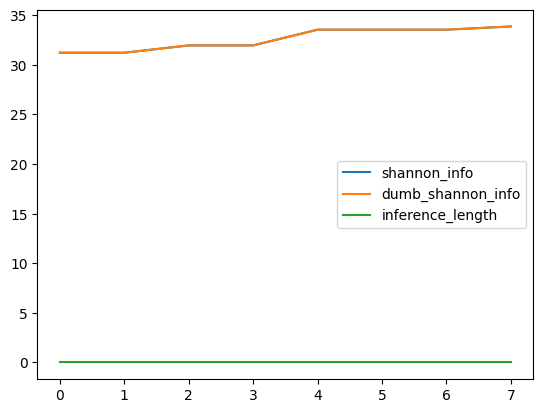

In [157]:
pd.DataFrame(bot1.statistics).plot()

In [54]:
bot1 = LitBot(
    1,
    1,
    2,
    action_data["player_count"],
    initial_game_state_array=np.where(np.array(action_data["card_location_array"])==4, 1, 0)
)

In [151]:
move_id = 37
move_id = str(move_id)
print(action_data["actions"][move_id])
print("truth matrix sum before")
print(bot1.truth_matrix.sum(axis=(2,3)))
print("\ncard count before")
print(bot1.player_card_count)
print("\nrecent card before")
print(bot1.recent_card_array)
print("\ninfo matrix before")
print(bot1.information_matrix[:,:, action_data["actions"][move_id]["set_id"]])

bot1.update_game({move_id : action_data["actions"][move_id]})

print("truth matrix sum after")
print(bot1.truth_matrix.sum(axis=(2,3)))
print("\ncard count after")
print(bot1.player_card_count)
print("\ninfo matrix after")
print(bot1.information_matrix[:,:, action_data["actions"][move_id]["set_id"]])

{'action': 'ask_card', 'by_team': 1, 'by': 0, 'to_team': 0, 'to': 1, 'set_id': 0, 'card_id': 5, 'result': 0}
truth matrix sum before
[[2. 2. 3.]
 [7. 7. 3.]]

card count before
[[ 6  4  6]
 [16  7  9]]

recent card before
[[0.01 3.   5.   0.   5.   0.01 0.01 0.01]
 [5.   0.01 0.   0.01 3.   0.01 5.   2.  ]]

info matrix before
[[[0.   0.01 0.01 0.01 0.01 0.  ]
  [0.   0.01 0.01 0.01 0.01 0.  ]
  [0.   0.01 0.01 0.01 0.01 0.  ]]

 [[1.   0.01 0.01 0.01 0.01 0.  ]
  [0.   0.   0.   0.   0.   1.  ]
  [0.   0.01 0.01 0.01 0.01 0.  ]]]
37 : updated information matrix for (0, 5) for result 0 : hard
37 : player card count completeness for (1, 1) : hard
37 : set card count completeness for [3] : hard
37 : set card count completeness for [4] : hard
37 : set card count completeness for [6] : hard
truth matrix sum after
[[2. 2. 3.]
 [7. 7. 3.]]

card count after
[[ 6  4  6]
 [16  7  9]]

info matrix after
[[[0.   0.01 0.01 0.01 0.01 0.  ]
  [0.   0.01 0.01 0.01 0.01 0.  ]
  [0.   0.01 0.01 0.01 0

In [146]:
bot1.inference_matrix.sum(axis=(-1))


array([[[0., 0., 0., 2., 0., 0., 0., 0.],
        [0., 0., 0., 2., 0., 0., 0., 0.],
        [0., 0., 1., 2., 0., 0., 0., 0.]],

       [[1., 0., 0., 0., 5., 0., 1., 0.],
        [1., 1., 0., 0., 0., 0., 3., 2.],
        [0., 0., 0., 0., 1., 0., 2., 0.]]])